In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.time import Time

# Take MJD 54195 as the Beginning of Transit (BoT):
BoT_mjd = 54195
# ... in decimalyear:
BoT_decyear = 2007.2589

In [2]:
# For the actual period folding, we will take the beginning of the 2007 transit as the beginning of the phase
# Thus, the beginning of the first window, BoT_mjd, is taken as the phase phi = 0

# First, define beginning and end of the three windows corresponding to the three major dimming events
# These params has been deduced from the SuperWASP-data on the 2007 transit (see Mamajek et. al., 2012)
t0 = 0 # First Dimming: 0-4 days since beginning of transit
t1 = 4 

t2 = 12 # Big, central Dimming: 12-42 days
t3 = 42

t4 = 48 # Third Dimming: 48-52 days
t5 = 52

# The heart of the PFA
# counting_points takes the data as "Light" and a test period "Period"
#  and, after folding "Light" into the period "Period, gives out the number of observations
#  that are laocated in any of the three windows
# Input: Light is array with data: col 0 = MJD of observation, col 1 = free
def counting_points(Light, Period):
    for i, Entry in enumerate(Light): # For every observation ...
        Light[i,1] = np.remainder(Entry[0]-(BoT_mjd), Period*365.24) # Calc phase...

    observations = sum(1 for j in Light if (t0<j[1]<t1) | (t2<j[1]<t3) | (t4<j[1]<t5)) # Calc Number of obs' in any of the threee windows
    return (observations) # return the number of observations in those windows

In [5]:
### Read in data
# Caution: PFA only works when column "0" = MJD, column "1" should be free

### Read in data
# Caution: PFA only works when column "0" = MJD
# For demonstrative purposes, we here set up the AAVSO data
folder = os.getcwd()
data = open(folder + "/aavsodata_J_2017_11_11.txt", 'r').readlines()[1:] # Skip header
lc_A = np.zeros((len(data), 2))
print ("Data from AAVSO on J1407 : " + str(len(lc_A)))

# Make lightcurve of AAVSO
for (i, entry) in enumerate(data):
    words = entry.split()
    t = Time(float(words[0]), format='jd', scale='utc')
    lc_A[i,0] = t.mjd

# Make final lightcurve with more than one sources
# When just used with AAVSO, ignore this paragraph
lightcurve = np.zeros((len(lc_A), 2))
j = 0
for array in [lc_A]:
    for entry in array:
        lightcurve[j, 0] = entry[0]
        j=j+1

Data from AAVSO on J1407 : 4342


In [11]:
### Actual Period Search
# Warning: This will take some time depending on "s" and length of data!
# With all data and 10k steps per year, runtime is about 11.5 hours
# Though: 0.1k and plate data shows most and is fast

p0 = 1.     # Start period
p1 = 10.    # End period

# Step size in decimal years. Uncomment desired
s = 0.01     # 0.1k steps per year (fastest)
#s = 0.001    # 1k steps
#s = 0.0001   # 10k steps (most precise, longest)

# Calc number of observations in the original transit,
#  since the PFA also counts the observations of the transit on 2007.
# Not necessary with only plateor AAVSO data
transit = counting_points(lightcurve, 2000)

# Define array for results of PFA
#  col "0" = respective test period, col "1" = counted number of ob's in windows
num_of_obs = np.zeros((int((p1-p0)/s),2))

# Run actual PFA
for i in range(int((p1-p0)/s)):
    # For all test periods ...
    p = p0+s*i
    num_of_obs[i,0] = p
    # ... Calc number of ob's in any of these three windows minus transit ob's:
    num_of_obs[i,1] = counting_points(lightcurve, p) - transit


# "Zeroes" is list with all the possible periods,
#  i.e. all test periods where not a single observation is present in any of the three windows
Zeroes = num_of_obs[num_of_obs[:,1]<1.][:,0]
#print (Zeroes)

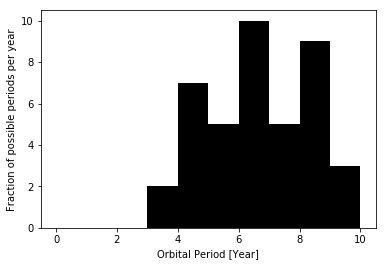

In [14]:
### Plot the results

# For normal histogramme
plt.hist(Zeroes, bins=[x for x in range(int(p1)+1)], fc="k")
plt.xlabel("Orbital Period [Year]")
plt.ylabel("Fraction of possible periods per year")
#plt.savefig("zeroes.pdf")
plt.show()